# **Description**

In [ ]:
# Construction of the Clasification Model for Ultrasonic Rail Inspection Data by AVIСON-11 Flaw Detector
# Ultrasonic channel data is used: 0.
# Synthetic data is used for training. For testing - real data collected from the railway
# Data divided into 4 classes
# kaazdes@gmail.com

# **Import**

In [1]:
import math
import random
import sys
import io
import os
from time import time
import copy

from google.colab import runtime
from IPython.display import clear_output #

import tensorflow as tf

import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import (
    MultipleLocator, FormatStrFormatter, AutoMinorLocator
)

import seaborn as sns
sns.set()
from yellowbrick.classifier import ClassBalance

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras import models
from keras import layers
from keras import backend as K
from keras.models import Sequential, Model
from keras import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import plot_model

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

# **Function**

In [15]:
#@title Read amount examples in data file
def read_amount_expls(patch_dir_file='/content/sample_data/Dataset_4/train/'):
  '''Returns amount of labels tensor in bin file '''
  labels_name = patch_dir_file + 'labels.bin' # метки кадров данных
  # Чтение данных из файла
  with open(labels_name, 'rb') as labels_file: # открытие бинарного файла и создание файлового объекта
      # узнаём размер файла
      labels_file.seek(0, io.SEEK_END);
      amount_expls = labels_file.tell();
  return amount_expls

In [16]:
#@title Arr_DataGenerator
def Arr_DataGenerator(patch_dir_file='/content/sample_data/Dataset_4/train/',
                      batch_size=32,
                      frame_size=(1000, 200),
                      num_classes=4,
                      reshape=True,
                      tocategor=True,
                      shuff=True,
                      norm=True,
                      Ampl=True):
    """
    Block-by-block reading of data and labels from binary files
    From the specified patch_dir_file directory
    - reads data from images.bin file (frames (frame_size size) of defectograms)
    - reads data from the labels.bin file (corresponding labels (classes))
    Mixes, normalizes data,  Vectors tags
    output:
    train_data    - (batch_size, 1024, 224, 1) data tensor for training
    train_labels  - (batch_size, NUM_CLASSES)tag tensor for learning
    """
    offset = 0
    offset_data = 0
    frame_l = frame_size[0] #
    frame_w = frame_size[1] #

    dat_name = patch_dir_file + 'images.bin' #  defectogram frames
    labels_name = patch_dir_file + 'labels.bin' # data frame label

    # Reading data from a file
    with open(labels_name, 'rb') as labels_file: #
        # file size
        labels_file.seek(0, io.SEEK_END);
        size_file_labels = labels_file.tell();
        offset = 0

    while True:
        if offset < (size_file_labels) :
          # Did not reach the end of the file. Continue reading
          offset = offset
          offset_data = offset_data
        else:
          # Reached the end of the file. Go to the beginning and read again
          offset = 0
          offset_data = 0

        # Tagging
        with open(labels_name, 'rb') as labels_file: #
            labels_file.seek(offset, io.SEEK_SET)
            Y_train = (np.fromfile(labels_file, dtype="uint8", count = batch_size * 1, sep = '' ))
            Y_train = Y_train.astype('float32')

        # work with data
        with open(dat_name, 'rb') as dat_file: #
            dat_file.seek(offset_data, io.SEEK_SET)
            X_train = (np.fromfile(dat_file, dtype="uint8", count = batch_size * frame_l * frame_w * 1, sep = '' ))
            X_train = X_train.astype('float32') #
        if Ampl==False:
          X_train[X_train>0] = 1

        if norm==True:
          X_train = (X_train - np.min(X_train))/np.ptp(X_train) #

        if reshape==True:
          X_train = np.reshape(X_train, (batch_size, frame_l, frame_w, 1)) # Tensor  1D --> 3D shape 4x
        else:
          X_train = np.reshape(X_train, (batch_size, frame_l, frame_w)) # Tensor  1D --> 3D  shape 3x

        if tocategor==True:
          Y_train = to_categorical(Y_train, num_classes) # vectorization labels
        if shuff==True:
          X_train, Y_train = shuffle(X_train, Y_train) # schuffle data

        # X_train = np.flip(X_train, axis=2) # right visualization
        # X_train = np.rot90(X_train, k=1, axes=(1, 2)) # rotation internal matrix
        # X_train = np.flip(X_train, 1)

        offset += batch_size
        offset_data += batch_size * frame_l * frame_w * 1 # !!! Dont FORGET 1 = byte  ---offset
        yield X_train, Y_train

In [17]:
#@title Read_one_example
def Read_one_example(patch_dir_file='/content/sample_data/Dataset_4/train/',
                      batch_size=1,
                      frame_size=(1024, 224),
                      num_classes=4,
                      reshape=True,
                      tocategor=True,
                      shuff=False,
                      norm=False,
                      index_example=0,
                      Ampl=True):
    """
    Reads one copy of their binary date and label files
    From the specified patch_dir_file directory
    - reads data from image.bin file (frames (frame_size) of defectogram)
    - reads data from labels.bin file (corresponding labels (classes))
    Mixes, normalizes data,  Vectors tags
    output:
    train_data    - (batch_size, 1024, 224, 1) data tensor for training
    train_labels  - (batch_size, NUM_CLASSES)tag tensor for learning
    """
    offset = 0
    offset_data = 0
    frame_l = frame_size[0] #
    frame_w = frame_size[1] #

    dat_name = patch_dir_file + 'images.bin' #  defectogram frames
    labels_name = patch_dir_file + 'labels.bin' # data frame label

    offset += index_example * batch_size #  offset for labels
    offset_data += index_example * batch_size * frame_l * frame_w * 1 # !!! Dont FORGET 1 = byte  ---offset for data

    # Tagging
    with open(labels_name, 'rb') as labels_file: #
        labels_file.seek(offset, io.SEEK_SET)
        Y_train = (np.fromfile(labels_file, dtype="uint8", count = batch_size * 1, sep = '' ))
        Y_train = Y_train.astype('float32')

    # work with data
    with open(dat_name, 'rb') as dat_file: #
        dat_file.seek(offset_data, io.SEEK_SET)
        X_train = (np.fromfile(dat_file, dtype="uint8", count = batch_size * frame_l * frame_w * 1, sep = '' ))
        X_train = X_train.astype('float32') #

    if Ampl==False:
          X_train[X_train>0] = 1

    if norm==True:
      X_train = (X_train - np.min(X_train))/np.ptp(X_train) #

    if reshape==True:
      X_train = np.reshape(X_train, (batch_size, frame_l, frame_w, 1)) # Tensor  1D --> 3D shape 4x
    else:
      X_train = np.reshape(X_train, (batch_size, frame_l, frame_w)) # Tensor  1D --> 3D  shape 3x

    if tocategor==True:
      Y_train = to_categorical(Y_train, num_classes) # vectorization labels
    if shuff==True:
      X_train, Y_train = shuffle(X_train, Y_train) # schuffle data

    return X_train, Y_train

In [18]:
#@title Read_label_bin
def Read_label_bin(patch_dir_file='/content/sample_data/Dataset_4/train/',
                   num_classes=4,
                   reshape=True,
                   tocategor=True,
                   shuff=True):
    """
    Block-by-block reading of data and labels from binary files
    From the specified patch_dir_file directory
    - reads data from labels.bin file (corresponding labels (classes))
    Mixes, normalizes data,  Vectors tags
    Exit:
    train_labels  - (batch_size, NUM_CLASSES) tag tensor for learning
    """
    offset = 0
    labels_name = patch_dir_file + 'labels.bin' # data frame label

    # Reading data from a file
    with open(labels_name, 'rb') as labels_file:
        #
        labels_file.seek(0, io.SEEK_END);
        size_file_labels = labels_file.tell();
        labels_file.seek(0, io.SEEK_SET);
        Y_train = (np.fromfile(labels_file, dtype="uint8", count = size_file_labels * 1, sep = '' ))
        Y_train = Y_train.astype('uint8')

        if tocategor==True:
          Y_train = to_categorical(Y_train, num_classes) # vectorization labels
    return Y_train

In [19]:
#@title Gen_COOArrBscan
def Gen_COOArrBscan(patch_dir_file,
                    batch_size= 32,
                    frame_size=(1000, 200),
                    num_classes=4,
                    shuff=True,
                    norm=True,
                    pr=False,
                    num_reset=10e32,
                    ampl=True,
                    tocategor=True,
                    reshape=True):
    """
    Details reads data and labels of their files images.bin, labels.bin
    batch_size - размер блока данных
    frame_size - размер каждого экземпляра данных. здесь (1000, 200)
    Output COOmatrix  (batch_size, XXX, 3, 1)
    """
    frame_l = frame_size[0] #
    frame_w = frame_size[1] #


    gen = Arr_DataGenerator(patch_dir_file='/content/sample_data/Dataset_4/train/',
                            batch_size=batch_size,
                            frame_size=frame_size,
                            num_classes=num_classes,
                            shuff=False,
                            norm=False,
                            reshape=False,
                            tocategor=False)
    m = 1
    #
    while True:

        x, y = next(gen)

        if (batch_size * m) >= num_reset:
          gen = Arr_DataGenerator(patch_dir_file='/content/sample_data/Dataset_4/train/',
                          batch_size=batch_size,
                          frame_size=frame_size,
                          num_classes=num_classes,
                          shuff=False,
                          norm=False,
                          reshape=False,
                          tocategor=False)
          m = 1

        l_max = 1500
        coo_data = np.empty((batch_size, l_max, 3))
        for i in range(batch_size):
          coo_frame = np.zeros((l_max, 3))
          frame = x[i]
          # print('frame.shape = ', frame.shape)
          rows_columns = np.nonzero(frame) # non-zero element indexes in the source matrix
          # print('rows_columns.shape[0] = ', len(rows_columns[0])
          # frame[frame > 0] = 1 # IF WE WANT TO TEST THE AMPLITUDE EFFECT
          values = frame[frame > 0] # values of all non-zero elements in the ref matrix
          coo_arr = np.vstack((rows_columns, values)).T # сжатая матрица СОО
          # print('coo_arr.shape[0] = ', coo_arr.shape)
          coo_frame[np.nonzero(coo_arr)] = coo_arr[coo_arr > 0] # insert into the extended zero matrix our compressed
          coo_data[i] = coo_frame
        if ampl == False:
          X_train = coo_data[:, :, :2] # eliminate amplitude
        else:
          X_train = coo_data
        # Form changes data
        if reshape==True:
          X_train = np.reshape(X_train, (batch_size, l_max, X_train.shape[2], 1))
        # vectorization
        Y_train = y
        if tocategor==True:
          Y_train = to_categorical(Y_train, num_classes) # vectorization labels
        # Data mixing
        if shuff==True:
          X_train, Y_train = shuffle(X_train, Y_train)
        # normalization
        if norm == True:
          X_train = (X_train - np.min(X_train)) / np.ptp(X_train) #

        m = m + 1

        yield X_train, Y_train

In [20]:
#@title FUNC Labels HOT ENCODING
def categor_lab(labels):
  '''labels to_catecorical labels HOT coding'''
  labels = labels.numpy()
  labels = to_categorical(y=labels, num_classes=NUM_CLASSES)
  return labels

def py_categor(label):
  '''HOT coding for mapping labels of tf.data.Dataset '''
  [categor_label,] = tf.py_function(func=categor_lab, inp=[label], Tout=[tf.float32])
  categor_label.set_shape((NUM_CLASSES,))
  return categor_label

In [21]:
#@title FUNC create_tfrecordfile
def create_tfrecordfile(patch_dir_bin_file = '/content/sample_data/Dataset_5/train/',
                       patern_name_rez_file='train',
                       type_of_data='int',
                       batch=200,
                       shuf=False,
                       Ampl=True):
  '''
  Поблочно читает данные из исходных бинарных файлов images и labels и записывает
  в файлы формата tfrecord
  Возвращает количество экземляров данных:  amount_expls
  patch_dir_bin_file - путь исходных файлов images.bin и labels.bin
  patern_name_rez_file - шаблон имени сохраняемых файлов. Обычно train, test, valid ...
  type_of_data - тип сохраняемых данных либо 'int' = tf.uint8 или 'float'=tf.float32
  batch=200 - размер блока читаемых и записываемых данных
  '''
  # Init / Set
  if type_of_data=='int':
    norm_act = False
    type_numpy = np.uint8
    type_tf    = tf.uint8
  else:
    norm_act = True
    type_numpy = np.float32
    type_tf    = tf.float32

  tf_rec_image_file  = patern_name_rez_file + '_images.tfrecord'
  tf_rec_labels_file = patern_name_rez_file + '_labels.tfrecord'
  # Preperd generator from original bin
  gen = Arr_DataGenerator(patch_dir_file=patch_dir_bin_file,
                          batch_size=batch,
                          frame_size=FRAME_SIZE,
                          num_classes=NUM_CLASSES,
                          shuff=shuf,
                          norm=norm_act,
                          reshape=False,
                          tocategor=False,
                          Ampl=Ampl)
  # debug  Checking generator operation
  # gen_data, gen_labels = next(gen)
  # print('Data shape in Original bin files ')
  # print(gen_data.shape, ' - Data shape ')
  # print(gen_labels.shape, ' - Label shape')
  amount_expls = read_amount_expls(patch_dir_file=patch_dir_bin_file) # read file with labels and count amount examples
  # debug
  # amount_expls = batch
  print(amount_expls, ' - amount of examples in original bin data file')

  # Write to TFRecord from original bin file
  print('Read batches data from bin file and write to TFRecord format. Process is : ')
  with tf.io.TFRecordWriter(tf_rec_image_file) as images_writer:     # data
    with tf.io.TFRecordWriter(tf_rec_labels_file) as labels_writer:  # labels

      for count in range(int(amount_expls // batch)):
        # Iterate over all batches
        print(count, end=" * ")
        gen_data, gen_labels = next(gen)

        for i in range(gen_data.shape[0]):
          # Iterate over all elements into each batch
          elem = gen_data[i].flatten().astype(dtype=type_numpy)
          record_byte = tf.io.serialize_tensor(elem)
          record_byte = record_byte.numpy()
          images_writer.write(record_byte)

          record_labels = tf.io.serialize_tensor(gen_labels[i].astype(dtype=type_numpy))
          labels_writer.write(record_labels.numpy())
  print('\nDone')
  return amount_expls

In [22]:
#@title FUNC Configure train process
def configure_for_performance(ds, batch_size=16):

  ds = ds.batch(batch_size=batch_size, drop_remainder=True)
  # ds = ds.cache()
  # ds = ds.prefetch(buffer_size=AUTOTUNE)
  ds = ds.repeat()
  return ds

In [23]:
#@title FUNC create_zip_ds and ds_data
type_tf    = tf.float32
# Cheking of batches reading from the created TFRecord file
parse_tensor = lambda x: tf.io.parse_tensor(x, tf.uint8)
reshape_tensor = lambda x: tf.reshape(x, (frame_L, frame_W, 1))
float_tensor = lambda x: tf.cast(x, type_tf)
normalize_tensor = lambda x: tf.keras.utils.normalize(x, axis=-1, order=2)

def create_zip_ds(filenames=('train_images.tfrecord', 'train_labels.tfrecord'),
                  batch_size=16):
  ds_data = (tf.data.TFRecordDataset(filenames[0], name='images').
             map(map_func=parse_tensor, num_parallel_calls=AUTOTUNE).
             map(map_func=reshape_tensor, num_parallel_calls=AUTOTUNE).
             map(map_func=float_tensor, num_parallel_calls=AUTOTUNE)
             )
  ds_labels = (tf.data.TFRecordDataset(filenames[1], name='labels').
               map(parse_tensor, num_parallel_calls=AUTOTUNE).
               map(float_tensor, num_parallel_calls=AUTOTUNE).
               map(py_categor, num_parallel_calls=AUTOTUNE)
               )

  ds = tf.data.Dataset.zip((ds_data, ds_labels))
  ds = configure_for_performance(ds=ds, batch_size=batch_size)
  return ds

def create_ds_data(filenames='train_images.tfrecord',
                    batch_size=16):
  ds_data = (tf.data.TFRecordDataset(filenames, name='images').
             map(map_func=parse_tensor).
             map(map_func=reshape_tensor).
             map(map_func=float_tensor)
             )
  ds_data = ds_data.batch(batch_size=batch_size, drop_remainder=True)
  return ds_data

# **Initialisation**

In [27]:
# @title Global_Variable
NUM_CLASSES = 4
BATCH_SIZE = 16
SEED = 2
FRAME_SIZE = (1024, 224)

frame_L = FRAME_SIZE[0]
frame_W = FRAME_SIZE[1]

Ampl = True # if you would like to use Amplitudes in a data
Avicon_frame_amount = 5360

In [28]:
# @title Set_Directory

train_dir = '/content/sample_data/Dataset_5/train/'   # synthetic data
valid_dir   = '/content/sample_data/Dataset_5/valid/' # synthetic data
test_dir  = '/content/sample_data/Dataset_5/test/'    # synthetic data
test_avikon_dir  ='/content/sample_data/Dataset_5/test_avikon_4/' # real data / flaw detector Avicon
# test_avikon_dir  = '/content/sample_data/Dataset_5/test_avikon_4_no_Shuffle/'
# synt_and_avicon_dir  ='/content/sample_data/Dataset_5/synt_and_avicon/' # тренировочные 512 и + авикон 512
path_best_model = ''

In [29]:
# @title HW Details
!ls sample_data
!ls /proc/driver/nvidia/gpus/
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md
ls: cannot access '/proc/driver/nvidia/gpus/': No such file or directory
cat: '/proc/driver/nvidia/gpus/0000:00:04.0/information': No such file or directory


In [30]:
# @title Copy Dataset to virt Machine
# Copy dataset from GoogleDrive to virtal Google Machine
!rsync -r --info=progress2 /content/drive/MyDrive/Data_Colab/Dataset_1Article/Dataset_5/  /content/sample_data/

     22,642,210 100%    7.68MB/s    0:00:02 (xfr#6, to-chk=0/7)


In [31]:
#@title Unzip Dataset
print('****** Extracting process: ')
!unrar x /content/sample_data/Dataset_5.rar /content/sample_data/
print('****** Directory consist: ')
!ls /content/sample_data/Dataset_5/

****** Extracting process: 

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/sample_data/Dataset_5.rar

Creating    /content/sample_data/Dataset_5                            OK
Extracting  /content/sample_data/Dataset_5/Description dataset.docx        2%  OK 
Creating    /content/sample_data/Dataset_5/test                       OK
Extracting  /content/sample_data/Dataset_5/test/images.bin                13%  OK 
Extracting  /content/sample_data/Dataset_5/test/labels.bin                13%  OK 
Creating    /content/sample_data/Dataset_5/test_avikon_4              OK
Extracting  /content/sample_data/Dataset_5/test_avikon_4/images.bin       67%  OK 
Extracting  /content/sample_data/Dataset_5/test_avikon_4/labels.bin       67%  OK 
Creating    /content/sample_data/Dataset_5/test_avikon_4_no_Shuffle   OK
Extracting  /content/sample_data/Dataset_5/test_avikon_4_no_Shuffle/images.bin      77%

# **Dataset Visualization**

(16, 1024, 224)  - Data shape 
<class 'numpy.ndarray'>
0.0  /  15.0      min/ max data
(16,)  - Label shape
<class 'numpy.ndarray'>
0.0  /  3.0      min/ max labels
[1. 3. 0. 0. 2. 3. 0. 0. 0. 1. 3. 1. 2. 0. 0. 0.]   labels example
Shape for vizu :  (16, 224, 1024)


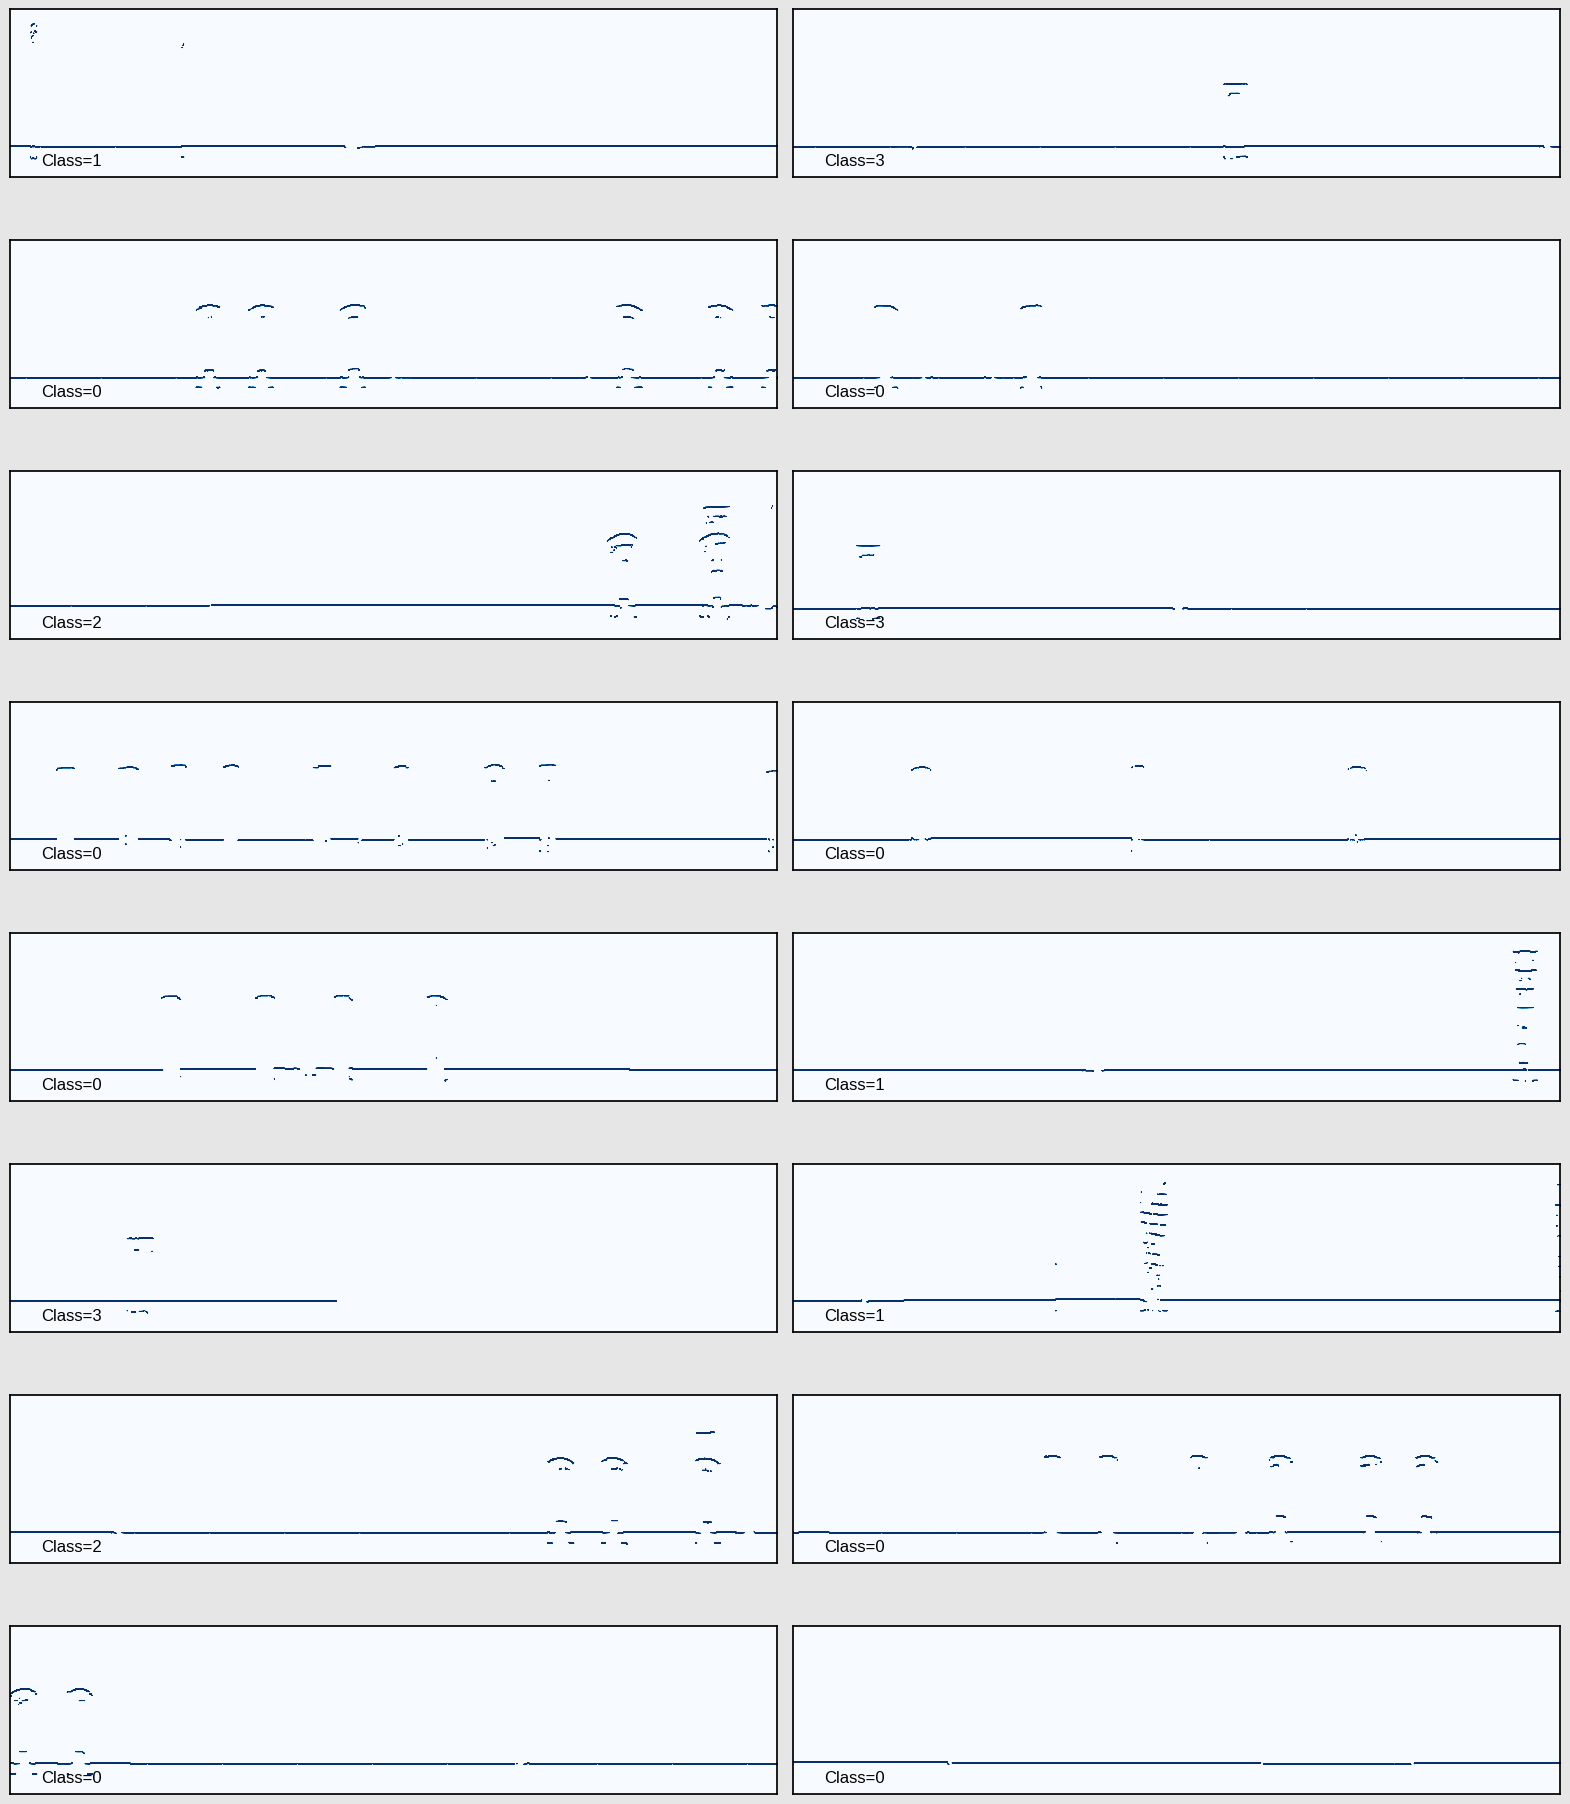

In [33]:
# @title Checking iterator real B-scan from bin file
# Check shape of data tensors and visualization
chek = Arr_DataGenerator(patch_dir_file=test_avikon_dir, # test_avikon_dir  train_dir
                         batch_size=BATCH_SIZE,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=False,
                         tocategor=False,
                         Ampl=Ampl)
# check_data, check_labels = next(chek)
for i in range(0, 44, 1):
  check_data, check_labels = next(chek)

print(check_data.shape, ' - Data shape ')
print(type(check_data))
print(check_data.min(), ' / ', check_data.max(), '     min/ max data')

print(check_labels.shape, ' - Label shape')
print(type(check_labels))
print(check_labels.min(), ' / ', check_labels.max(), '     min/ max labels')
print(check_labels[0:], '  labels example')

# Visu examples
check_data = np.rot90(check_data, k=1, axes=(1, 2)) # rotation internal matrix
# check_data = np.flipud(check_data)
print('Shape for vizu : ', check_data.shape)
# check_data = np.flip(check_data, 1)
with plt.style.context('grayscale'):
  fig, ax = plt.subplots(8, 2, figsize=(20, 24), facecolor='0.9')
  fig.subplots_adjust(hspace=0, wspace=0.02)
  for i, axi in enumerate(ax.flat):
    axi.imshow(np.flipud(check_data[i+0,:,:] * 255), cmap='Blues', vmin=0, vmax=80)
    axi.set(xticks=[], yticks=[])
    axi.text(0.08, 0.07, 'Class=' + str(int(check_labels[i+0])), fontsize=12, ha='center', transform=axi.transAxes)

train:  (2048,) /  test:  (2048,) /  valid:  (2048,) /  avicon:  (5360,)
Data Report (Class Balance):

          train    test     valid     avicon
 
Class 0:   472     491      522      2151
Class 1:   523     500      529      1043
Class 2:   534     523      477      1584
Class 3:   519     534      520      582
___________________________________________
Total:    2048    2048     2048      5360


<ipython-input-35-bf1bdeab13d5>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(descriptio_x)


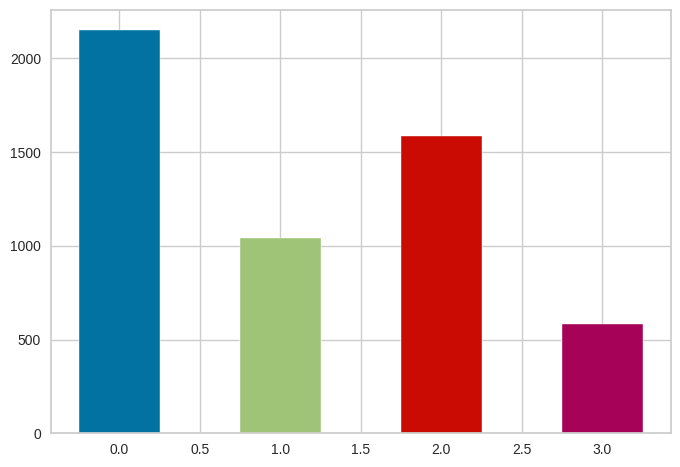

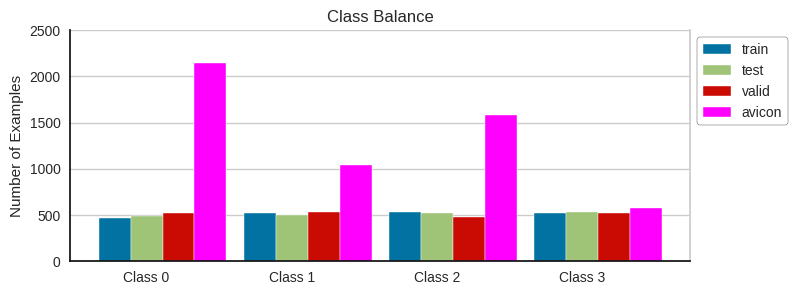

In [35]:
#@title ClassBalance Viz
n_lab_train = Read_label_bin(patch_dir_file=train_dir, tocategor=False)
n_lab_valid = Read_label_bin(patch_dir_file=valid_dir, tocategor=False)
n_lab_test  = Read_label_bin(patch_dir_file=test_dir,  tocategor=False)
n_lab_avicon  = Read_label_bin(patch_dir_file=test_avikon_dir,  tocategor=False)
print('train: ', n_lab_train.shape, '/  test: ', n_lab_test.shape, '/  valid: ', n_lab_valid.shape, '/  avicon: ', n_lab_avicon.shape)

labels_class = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
# labels_class = ['Class 0', 'Class 3']
cb_train_viz = ClassBalance(labels=labels_class)
cb_valid_viz = ClassBalance(labels=labels_class)
cb_test_viz  = ClassBalance(labels=labels_class)
cb_avicon_viz  = ClassBalance(labels=labels_class)

cb_train_viz.fit(n_lab_train);
cb_valid_viz.fit(n_lab_valid);
cb_test_viz.fit(n_lab_test);
cb_avicon_viz.fit(n_lab_avicon);

print('Data Report (Class Balance):')
print('')
print('          train    test     valid     avicon')
print(' ')
for i in range(len(cb_test_viz.support_)):
  print(f'Class {i}:  ', cb_train_viz.support_[i], '   ', cb_test_viz.support_[i], '    ', cb_valid_viz.support_[i],  '    ', cb_avicon_viz.support_[i])
print('___________________________________________')
print(f'Total:   ', cb_train_viz.support_.sum(), '  ', cb_test_viz.support_.sum(), '   ', cb_valid_viz.support_.sum(), '    ', cb_avicon_viz.support_.sum())

# Group graph for third dataset
descriptio_x = [f'Class {i}' for i in range(4)]
x = np.arange(len(descriptio_x))
width = 0.22
fig, ax = plt.subplots(figsize=(8, 3))
rects1 = ax.bar(x=(x - 2 * (width / 2)), height=cb_train_viz.support_, width=width, color='b',  label='train')
react2 = ax.bar(x=x,                     height=cb_test_viz.support_,  width=width, color='g', label='test')
react3 = ax.bar(x=(x + 2 * (width / 2)), height=cb_valid_viz.support_, width=width, color='r', label='valid')
react4 = ax.bar(x=(x + 4 * (width / 2)), height=cb_avicon_viz.support_, width=width, color='fuchsia', label='avicon')
ax.tick_params(axis='both', labelsize=10, color='g')
ax.set_xticklabels(descriptio_x)
ax.set_xticks(x)
ax.grid(axis='x')
ax.set_ylim([0, 2500])
ax.set_title('Class Balance')
ax.set_ylabel('Number of Examples')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=True, edgecolor='k', fontsize=10);
ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')

In [36]:
#@title Create  train / valid / test TFRecord FILES
debug = 512
data_type = 'int'
train_amount = create_tfrecordfile(patch_dir_bin_file = train_dir,
                                  patern_name_rez_file='train',
                                  type_of_data=data_type,
                                  batch=debug,
                                  Ampl=Ampl)
print('Train amount :', train_amount, '\n ________________________________________')

valid_amount = create_tfrecordfile(patch_dir_bin_file=valid_dir ,
                                  patern_name_rez_file='valid',
                                  type_of_data=data_type,
                                  batch=debug,
                                  Ampl=Ampl)
print('Valid amount :', valid_amount, '\n ________________________________________')

test_amount = create_tfrecordfile(patch_dir_bin_file=test_dir ,
                                  patern_name_rez_file='test',
                                  type_of_data=data_type,
                                  batch=debug,
                                  Ampl=Ampl)
print('Test amount :', test_amount, '\n ________________________________________')

test_avikon_dir_amount = create_tfrecordfile(patch_dir_bin_file=test_avikon_dir,
                                            patern_name_rez_file='avicon',
                                            type_of_data=data_type,
                                            batch=int(Avicon_frame_amount / BATCH_SIZE),
                                            shuf=False,
                                            Ampl=Ampl)
print('Test amount :', test_avikon_dir_amount, '\n ________________________________________')

2048  - amount of examples in original bin data file
Read batches data from bin file and write to TFRecord format. Process is : 
0 * 1 * 2 * 3 * 
Done
Train amount : 2048 
 ________________________________________
2048  - amount of examples in original bin data file
Read batches data from bin file and write to TFRecord format. Process is : 
0 * 1 * 2 * 3 * 
Done
Valid amount : 2048 
 ________________________________________
2048  - amount of examples in original bin data file
Read batches data from bin file and write to TFRecord format. Process is : 
0 * 1 * 2 * 3 * 
Done
Test amount : 2048 
 ________________________________________
5360  - amount of examples in original bin data file
Read batches data from bin file and write to TFRecord format. Process is : 
0 * 1 * 2 * 3 * 4 * 5 * 6 * 7 * 8 * 9 * 10 * 11 * 12 * 13 * 14 * 15 * 
Done
Test amount : 5360 
 ________________________________________


In [ ]:
#@title ZIP tfrecord files
# !zip -r 'labels_tfrecord.zip' 'labels.tfrecord'
# !zip -r 'images_tfrecord.zip' 'images.tfrecord'
# # !cp  '/content/sample_data/internet_128_256_v2.zip' /content/drive/MyDrive/Data_Colab/Data_Segment_Pegas/variant_5/

* ds_labels =  <_MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.float32, name=None)>
+ ds_labels  TensorSpec(shape=(4,), dtype=tf.float32, name=None)
---- <_MapDataset element_spec=TensorSpec(shape=(1024, 224, 1), dtype=tf.float32, name=None)>
Data format in file tfrecord : TensorSpec(shape=(1024, 224, 1), dtype=tf.float32, name=None)
Examples of batches: 
Batch shape (16, 1024, 224, 1)
labels [3 1 1 3 0 1 1 1 2 2 1 3 0 1 1 1]
<_ZipDataset element_spec=(TensorSpec(shape=(1024, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>
(16, 1024, 224, 1)
(16, 4)
***********************
(16, 4)
[3 1 1 3 0 1 1 1 2 2 1 3 0 1 1 1]
*************************
[15. 15. 15. ... 15. 15. 15.]
0.0  /  20.0      min/ max data


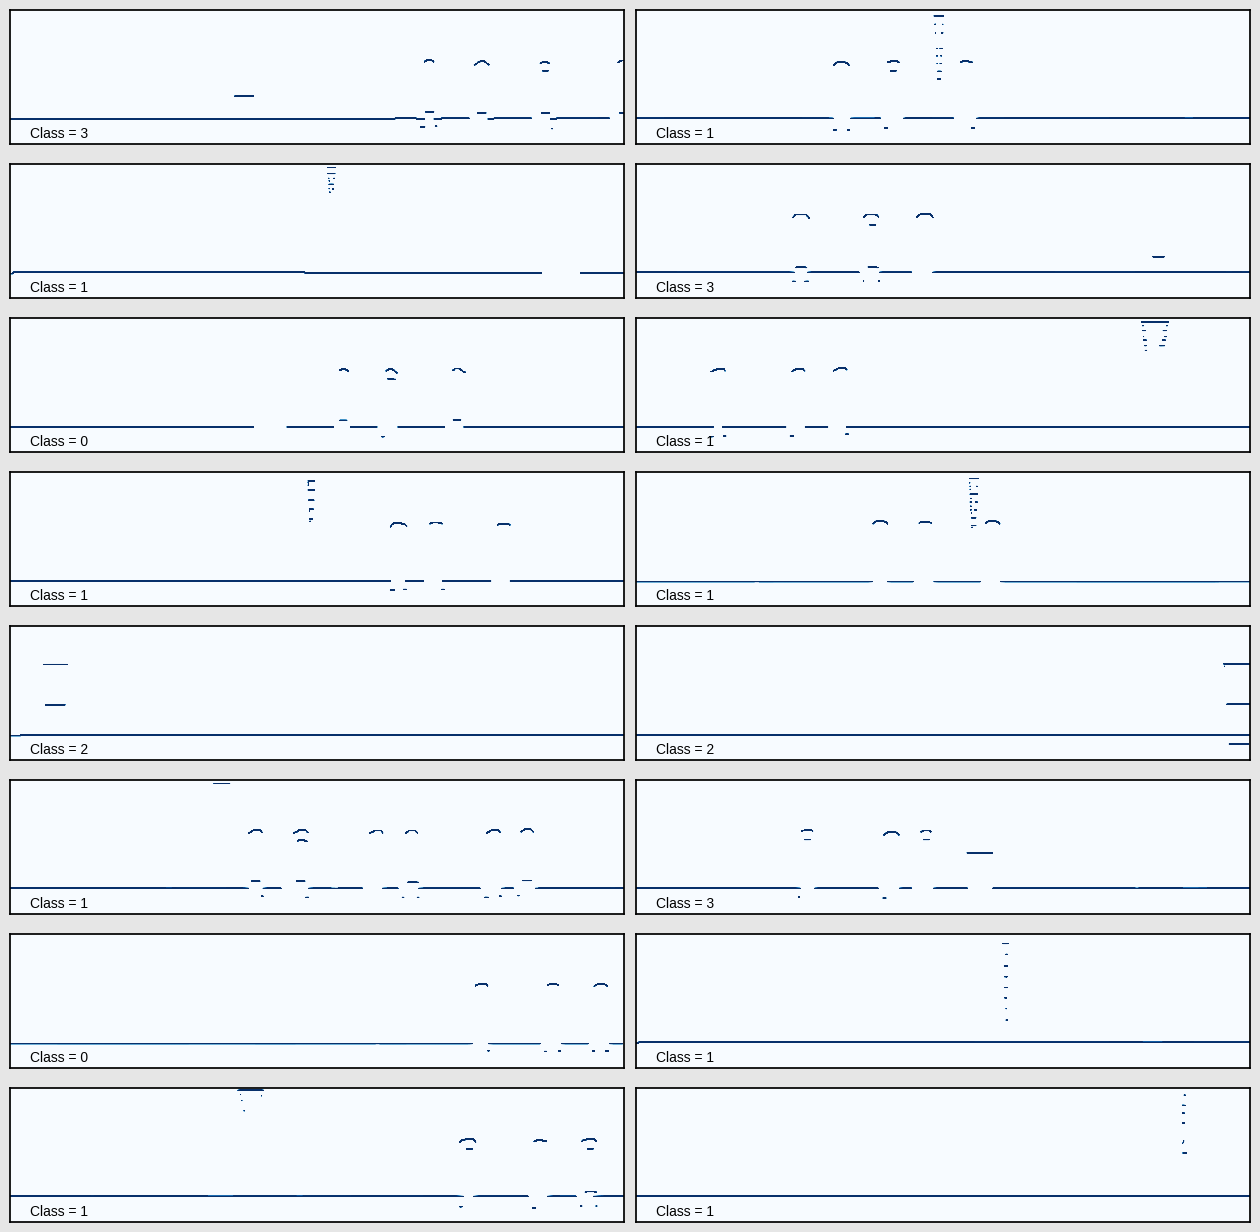

In [37]:
#@title Cheking of batches reading from the created TFRecord file
# Cheking of batches reading from the created TFRecord file
pre_name_data_set = 'train' # train, test, valid, avicon
type_data = 'float' # or

if type_data=='int':
  norm_act = False
  type_numpy = np.uint8
  type_tf    = tf.uint8
else:
  norm_act = True
  type_numpy = np.float32
  type_tf    = tf.float32
images_tfrecord_file = pre_name_data_set + '_images.tfrecord' # train
labels_tfrecord_file = pre_name_data_set + '_labels.tfrecord' # train


parse_tensor = lambda x: tf.io.parse_tensor(x, tf.uint8)
reshape_tensor = lambda x: tf.reshape(x, (frame_L, frame_W, 1))
float_tensor = lambda x: tf.cast(x, type_tf)
normalize_tensor = lambda x: tf.keras.utils.normalize(x, axis=-1, order=2)

ds_data = (tf.data.TFRecordDataset(filenames = images_tfrecord_file, name='images').
           map(map_func=parse_tensor).
           map(map_func=reshape_tensor).
           map(map_func=float_tensor)
           )
ds_labels = (tf.data.TFRecordDataset(filenames=labels_tfrecord_file, name='labels').
             map(parse_tensor).
             map(float_tensor).
             map(py_categor))

print('* ds_labels = ', ds_labels)
print('+ ds_labels ', ds_labels.element_spec)
print('----', ds_data)
print('Data format in file tfrecord :', ds_data.element_spec)
print('Examples of batches: ')
# For debug
for f in ds_data.batch(BATCH_SIZE).take(1):
  print('Batch shape', f.shape)

for lab in ds_labels.batch(BATCH_SIZE).take(1):
  print('labels', np.argmax(lab.numpy(), axis=1))

train_ds = tf.data.Dataset.zip((ds_data, ds_labels))
print(train_ds)

for d, l in train_ds.batch(BATCH_SIZE).take(1):
  print(d.shape)
  print(l.shape)

check_data = d.numpy()
check_labels = l.numpy()
print('***********************')
print(check_labels.shape)
print(np.argmax(check_labels,axis=1))
print('*************************')

# categ = py_categor(labels=lab)
# print(categ)
print(check_data[check_data>0])

# Visu examples
print(check_data.min(), ' / ', check_data.max(), '     min/ max data')
check_data = np.rot90(check_data, k=1, axes=(1, 2)) # rotation internal matrix
# check_data = np.flip(check_data, 1)
with plt.style.context('grayscale'):
  fig, ax = plt.subplots(8, 2, figsize=(16, 16), facecolor='0.9')
  fig.subplots_adjust(hspace=0, wspace=0.02)
  for i, axi in enumerate(ax.flat):
    axi.imshow(np.flipud(check_data[i+0,:,:] * 255), cmap='Blues', vmin=0, vmax=80)
    axi.set(xticks=[], yticks=[])
    axi.text(0.08, 0.05, 'Class = ' + str(np.argmax(check_labels[i+0])), fontsize=10, ha='center', transform=axi.transAxes)

# **Data analysis**

In [ ]:
#@title PCA.explained_variance_ratio
from sklearn.decomposition import PCA
batch = 2048
chek_train = Arr_DataGenerator(patch_dir_file=train_dir, # test_avikon_dir  train_dir
                         batch_size=batch,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=True,
                         tocategor=False,
                         Ampl=Ampl)
chek_avicon = Arr_DataGenerator(patch_dir_file=test_avikon_dir, # test_avikon_dir  train_dir
                         batch_size=batch,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=True,
                         tocategor=False,
                         Ampl=Ampl)
xtr, ytr = next(chek_train) #
xtr = np.reshape(xtr, (batch, xtr.shape[1] * xtr.shape[2]))

xav, yav = next(chek_avicon) #
xav = np.reshape(xav, (batch, xav.shape[1] * xav.shape[2]))
n_comp_pca = 1000

pca_train  = PCA(n_components=n_comp_pca, svd_solver="randomized", whiten=False).fit(xtr)
pca_avicon = PCA(n_components=n_comp_pca, svd_solver="randomized", whiten=False).fit(xav)


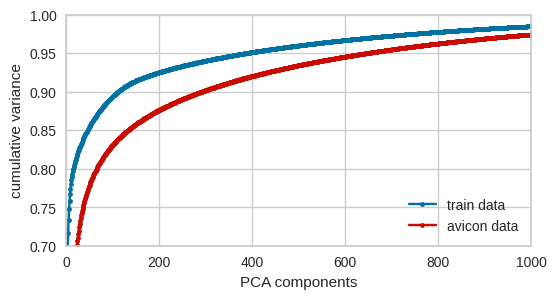

In [ ]:
fig =  plt.figure(figsize=(6, 3))
plt.plot(np.cumsum(pca_train.explained_variance_ratio_), '.-b', label='train data') #
plt.plot(np.cumsum(pca_avicon.explained_variance_ratio_), '.-r', label='avicon data') #
plt.xlabel('PCA components')
plt.ylabel('cumulative variance')
plt.legend()
plt.xlim(0, n_comp_pca)
plt.ylim(0.7, 1);

In [ ]:
#@title PCA Graph
# from sklearn.decomposition import PCA

# instance of the model
model = PCA(n_components=2)
# Data preparation. Take a part to display
x_tr, x_im, y_tr, y_im = train_test_split(xav, yav, test_size = 0.95, random_state=25)
# Model fit
model.fit(x_im)
# Model projected
data2D_projected = model.transform(x_im)
print('Данные: ', data2D_projected.shape , 'Метки', y_im.shape, ': 2D')


Данные:  (1946, 2) Метки (1946,) : 2D


<ipython-input-21-d5339297c2bc>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Spectral', 4), vmax=3)


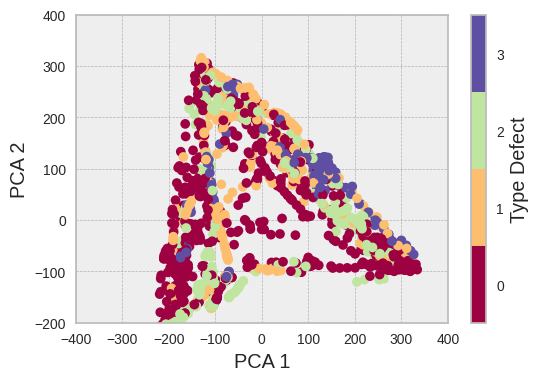

In [ ]:
# Construction of 2D result graphics
with plt.style.context('bmh'): # Solarize_Light2 grayscale
  fig =  plt.figure(figsize=(6, 4), facecolor='1')
  ax = plt.axes()
  transform = ax.transData
  plt.scatter(data2D_projected[:, 0], data2D_projected[:, 1],
              c = yim, edgecolor='none', alpha=1,
              cmap=plt.cm.get_cmap('Spectral', 4), vmax=3)
  plt.colorbar(label='Type Defect', ticks=range(7))
  plt.clim(-0.5, 3.5)
  # plt.title('______')
  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.xlim(-400, 400)
  plt.ylim(-200, 400)

In [ ]:
#@title LinearDiscriminantAnalysis Dimension reduction
# For reference we construct two-dimensional distribution LinearDiscriminantAnalysis(n_components=2)
# data preparation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
batch = 1024
chek = Arr_DataGenerator(patch_dir_file=train_dir, # test_avikon_dir  train_dir synt_and_avicon_dir
                         batch_size=batch,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=True,
                         tocategor=False,
                         Ampl=Ampl)
x1, y1 = next(chek)
# xtr, xim, ytr, yim = train_test_split(x1, y1, test_size = 0.85, random_state=25, shuffle=True)
data = np.reshape(x1, (batch, x1.shape[1] * x1.shape[2])) # each instance into a linear structure
target = y1
iso = LinearDiscriminantAnalysis(n_components=2)
# Model fit
data_projected = iso.fit_transform(data, target)

<ipython-input-24-010f867f482f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Spectral', 4), vmax=4)


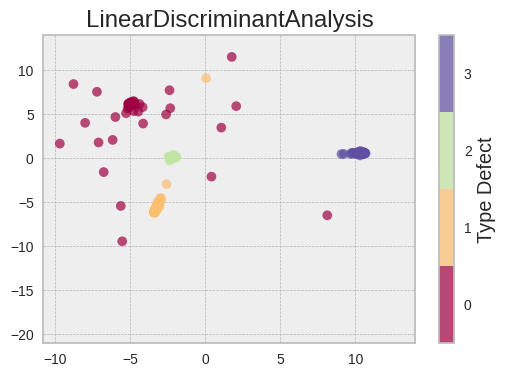

In [ ]:
# Construction of 2D result graphics
with plt.style.context('bmh'):
  fig =  plt.figure(figsize=(6, 4), facecolor='1')
  ax = plt.axes()
  transform = ax.transData
  plt.scatter(data_projected[:, 0], data_projected[:, 1],
              c = target, edgecolor='none', alpha=0.7,
              cmap=plt.cm.get_cmap('Spectral', 4), vmax=4)
  plt.colorbar(label='Type Defect', ticks=range(4))
  plt.clim(-0.5, 3.5)
  plt.title('LinearDiscriminantAnalysis')
  plt.xlim(-10.8, 14)
  plt.ylim(-21, 14);

In [ ]:
#@title LDA Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
batch = 1024
data = Arr_DataGenerator(patch_dir_file=train_dir, # test_avikon_dir  train_dir synt_and_avicon_dir
                         batch_size=batch,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=True,
                         tocategor=False,
                         Ampl=Ampl)
Xtr, Ytr = next(data)
Xtr = np.reshape(Xtr, (batch, Xtr.shape[1] * Xtr.shape[2])) # каждый экземпляр в линейную структуру

# Demention Reduction if needed
iso = LinearDiscriminantAnalysis(n_components=2)
Xtr_reduct = iso.fit_transform(Xtr, Ytr) #


# # Подгонка моделии
lda_model = LinearDiscriminantAnalysis(solver='svd') # store_covariance=True
# lda_model.fit(Xtr, Ytr)
lda_model.fit(Xtr_reduct, Ytr)

LinearDiscriminantAnalysis()

acc= 0.58203125
              precision    recall  f1-score   support

         0.0     1.0000    0.9254    0.9612        67
         1.0     0.3941    1.0000    0.5654        67
         2.0     0.0000    0.0000    0.0000        60
         3.0     0.9091    0.3226    0.4762        62

    accuracy                         0.5820       256
   macro avg     0.5758    0.5620    0.5007       256
weighted avg     0.5850    0.5820    0.5149       256



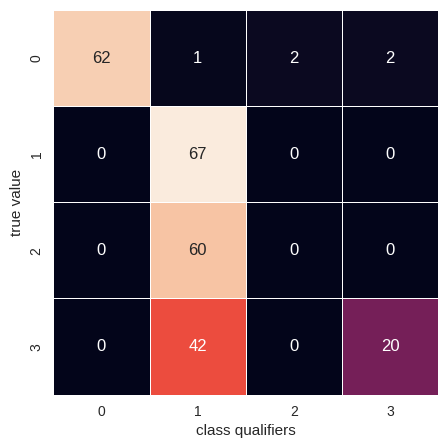

In [ ]:
from sklearn.metrics import accuracy_score
batch=256
data = Arr_DataGenerator(patch_dir_file=test_dir, # test_avikon_dir  train_dir synt_and_avicon_dir
                         batch_size=batch,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=False,
                         reshape=True,
                         tocategor=False,
                         Ampl=Ampl)
Xtest, Ytest = next(data)
Xtest = np.reshape(Xtest, (batch, Xtest.shape[1] * Xtest.shape[2])) #
Xtest_reduct = iso.fit_transform(Xtest, Ytest)

# y_model = lda_model.predict(Xtest)
y_model = lda_model.predict(Xtest_reduct)

acc = accuracy_score(Ytest, y_model)
print('acc=', acc)
print(classification_report(Ytest, y_model, digits=4))
mat = confusion_matrix(Ytest, y_model)
fig = plt.figure(figsize=(10, 5), facecolor='1')
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='d', linewidths=0.5)
plt.xlabel('сlass qualifiers')
plt.ylabel('true value');

In [ ]:
#@title RandomForestModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=800, verbose=0)
#  criterion='gini', min_samples_leaf=1,
#                             max_leaf_nodes=300, bootstrap=True
#
batch = 2048
# training data
train_gen = Arr_DataGenerator(patch_dir_file=train_dir, # test_avikon_dir  train_dir
                              batch_size=batch,
                              frame_size=FRAME_SIZE,
                              num_classes=NUM_CLASSES,
                              shuff=False,
                              norm=True,
                              reshape=False,
                              tocategor=False,
                              Ampl=Ampl)

Xtrain, ytrain = next(train_gen) #
Xtrain = np.reshape(Xtrain, (batch, Xtrain.shape[1] * Xtrain.shape[2]))  #
print(Xtrain.shape)
print(ytrain.shape)

# test data
test_gen = Arr_DataGenerator(patch_dir_file=test_dir, # test_avikon_dir  train_dir
                              batch_size=batch,
                              frame_size=FRAME_SIZE,
                              num_classes=NUM_CLASSES,
                              shuff=False,
                              norm=True,
                              reshape=False,
                              tocategor=False,
                              Ampl=Ampl)
Xtest, ytest = next(test_gen)
Xtest = np.reshape(Xtest, (batch, Xtest.shape[1] * Xtest.shape[2]))
# ytest = np.argmax(ytest, axis=1)  # ytest.shape = (50 000,)

rf.fit(Xtrain, ytrain) # обучение модели
acc = accuracy_score(ytest, rf.predict(Xtest))
print(acc, 'Accuracy RandomForestClassifier. Test data')

(2048, 229376)
(2048,)
0.25634765625 Точность RandomForestClassifier на тестовых 50 000 данных


# **Synthesis of NN**

In [38]:
#@title FUNC for building Block_Conv2D

def block(inp=tf.keras.Input(shape=FRAME_SIZE + (1,), dtype='float32', name='inp'),
          filters=(4, 8),
          first_blk=False,
          name='Blk_'):
  if first_blk==False:
    inp = layers.MaxPooling2D((4, 2), name=name + '_1')(inp)

  x = layers.Conv2D(filters=filters[0], kernel_size=(2, 2), padding='same', activation='relu', name=name + '_2')(inp)
  # x = layers.BatchNormalization(name=name+'_3')(x)
  x = layers.Conv2D(filters=filters[1], kernel_size=(2, 2), padding='same', activation='relu', name=name + '_4')(x)
  x = layers.Dropout(0.35)(x)

  block_out = x
  return block_out

In [40]:
#@title Model_1

tf.keras.backend.clear_session() # reset the model state in memory

def get_model_1(filters=[(4, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256)]):
  inp = tf.keras.Input(shape=FRAME_SIZE + (1,), dtype='float32', name='data_frame')
  b = inp
  first_blk=True
  for i in range(len(filters)):

    if i!=0:
      first_blk = False
    name = f'blk_{i+1}'
    b = block(inp=b, filters=filters[i], first_blk=first_blk, name=name)
  out = layers.Flatten()(b)
  out = layers.Dense(units=NUM_CLASSES, activation='softmax')(out) #softmax sigmoid
  model = Model(inp, out)
  return model

# best for binary filters=[(2, 2), (4, 4), (4, 4), (8, 8), (16, 16)]  unit=0
model_1 = get_model_1(filters=[(2, 2), (4, 4), (8, 8), (16, 16), (16, 16)]) #
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_frame (InputLayer)     [(None, 1024, 224, 1)]    0         
                                                                 
 blk_1_2 (Conv2D)            (None, 1024, 224, 2)      10        
                                                                 
 blk_1_4 (Conv2D)            (None, 1024, 224, 2)      18        
                                                                 
 dropout (Dropout)           (None, 1024, 224, 2)      0         
                                                                 
 blk_2_1 (MaxPooling2D)      (None, 256, 112, 2)       0         
                                                                 
 blk_2_2 (Conv2D)            (None, 256, 112, 4)       36        
                                                                 
 blk_2_4 (Conv2D)            (None, 256, 112, 4)       68    

In [ ]:
#@title Plot model_
struct_model_pict = '/content/drive/MyDrive/Data_Colab/Dataset_1Article/' +  'model_struct_CNN.png'
plot_model(model_1, show_shapes=True, to_file=struct_model_pict)

In [ ]:
#@title Compilation model
model = model_1
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=path_best_model + 'model_v16.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)]

In [ ]:
#@title Create zip_ds for  train / valid / test
AUTOTUNE = tf.data.AUTOTUNE
# For Training
train_ds  = create_zip_ds(filenames=('train_images.tfrecord', 'train_labels.tfrecord'), batch_size=BATCH_SIZE)
valid_ds  = create_zip_ds(filenames=('valid_images.tfrecord', 'valid_labels.tfrecord'), batch_size=BATCH_SIZE)
# For Analyse
test_ds   = create_zip_ds(filenames=('test_images.tfrecord', 'test_labels.tfrecord'), batch_size=BATCH_SIZE)
avicon_ds = create_zip_ds(filenames=('avicon_images.tfrecord', 'avicon_labels.tfrecord'), batch_size=BATCH_SIZE)
test_ds_data   = create_ds_data(filenames='test_images.tfrecord', batch_size=BATCH_SIZE)
avicon_ds_data = create_ds_data(filenames='avicon_images.tfrecord', batch_size=BATCH_SIZE) #
# Viz
print('Flows :')
print('Train flow  :', train_ds)
print('Valid flow  :', valid_ds)
print('Test flow   :', test_ds)
print('Avicon flow :', avicon_ds)
print('________________________')
print('Data only :')
print('Test data   :', test_ds_data)
print('Avicon data :', avicon_ds_data)

Flows :
Train flow  : <_RepeatDataset element_spec=(TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 4), dtype=tf.float32, name=None))>
Valid flow  : <_RepeatDataset element_spec=(TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 4), dtype=tf.float32, name=None))>
Test flow   : <_RepeatDataset element_spec=(TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 4), dtype=tf.float32, name=None))>
Avicon flow : <_RepeatDataset element_spec=(TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 4), dtype=tf.float32, name=None))>
________________________
Data only :
Test data   : <_BatchDataset element_spec=TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None)>
Avicon data : <_BatchDataset element_spec=TensorSpec(shape=(16, 1024, 224, 1), dtype=tf.float32, name=None)>


In [ ]:
#@title Run training NN
history = model.fit(valid_ds,
                    steps_per_epoch=int(train_amount / BATCH_SIZE),
                    epochs=50,
                    validation_data=train_ds,
                    validation_steps=int(valid_amount / BATCH_SIZE),
                    callbacks=callbacks_list)

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.9947 - acc: 0.5786
Epoch 1: val_loss improved from inf to 0.89567, saving model to /content/model_v16.h5model_v17.h5
128/128 [==============================] - 14s 90ms/step - loss: 0.9947 - acc: 0.5786 - val_loss: 0.8957 - val_acc: 0.8613
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.3809 - acc: 0.8652
Epoch 2: val_loss improved from 0.89567 to 0.58491, saving model to /content/model_v16.h5model_v17.h5
128/128 [==============================] - 10s 80ms/step - loss: 0.3809 - acc: 0.8652 - val_loss: 0.5849 - val_acc: 0.9106
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.2077 - acc: 0.9341
Epoch 3: val_loss improved from 0.58491 to 0.35648, saving model to /content/model_v16.h5model_v17.h5
128/128 [==============================] - 8s 60ms/step - loss: 0.2066 - acc: 0.9341 - val_loss: 0.3565 - val_acc: 0.9321
Epoch 4/50
128/128 [==============================] - ETA

In [ ]:
# Copy file of model to Google disk if it is needed
!cp  'model_v16.h5' '/content/drive/MyDrive/Colab Notebooks/'
# model.save(filepath='/content/drive/MyDrive/Colab Notebooks/latest_model_16.h5', overwrite=True)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


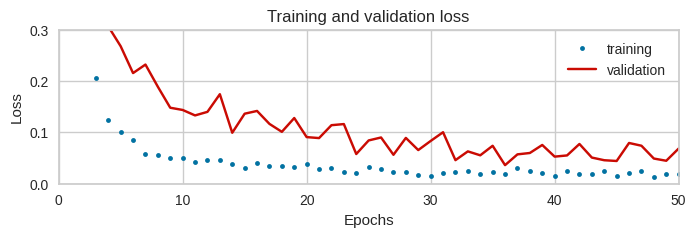

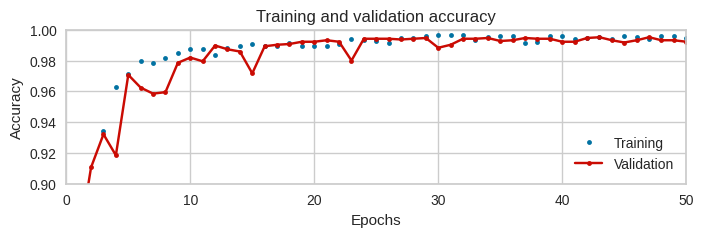

In [ ]:
#@title Analysis of the learning process
print(history.history.keys())
# Loss Chart
plt.figure(figsize=(8,2))
loss = history.history['loss'] #
val_loss = history.history['val_loss'] #
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b.', label='training')
plt.plot(epochs, val_loss, 'r', label='validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.ylim(0.0, 0.3); plt.xlim(0, 50)
plt.show()
# Accuracy Chart
acc = history.history['acc']
plt.figure(figsize=(8, 2))
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'b.', label='Training') #
plt.plot(epochs, val_acc, 'r.-', label='Validation') #
plt.title('Training and validation accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.xlim(0, 50); plt.ylim(0.9, 1); plt.legend()
plt.show()

# **Load & Analyse best model**

In [42]:
# Load model what you want to analyse
model = models.load_model(filepath='/content/drive/MyDrive/Colab Notebooks/model_v16.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_frame (InputLayer)     [(None, 1024, 224, 1)]    0         
                                                                 
 blk_1_2 (Conv2D)            (None, 1024, 224, 2)      10        
                                                                 
 blk_1_4 (Conv2D)            (None, 1024, 224, 2)      18        
                                                                 
 dropout (Dropout)           (None, 1024, 224, 2)      0         
                                                                 
 blk_2_1 (MaxPooling2D)      (None, 256, 112, 2)       0         
                                                                 
 blk_2_2 (Conv2D)            (None, 256, 112, 4)       36        
                                                                 
 blk_2_4 (Conv2D)            (None, 256, 112, 4)       68    

In [ ]:
#@title Model evaluation through test and avicon data
steps = test_amount / BATCH_SIZE
print('model.predict test data :')
test_loss, test_acc = model.evaluate(x=test_ds, steps=steps, verbose=1)
print('Amount of test data = ', test_amount)
print('test_loss = ', test_loss)
print('test_acc  =' , test_acc)
print('_______________________')

# Model evaluation on avicon data
steps = int(test_avikon_dir_amount / BATCH_SIZE)
print('model.predict avicon data :')
avicon_loss, avicon_acc = model.evaluate(x=avicon_ds, steps=steps, verbose=1)
print('Amount of test data = ', test_avikon_dir_amount) #
print('test_loss = ', avicon_loss)
print('test_acc  =' , avicon_acc)

model.predict test data :
128/128 [==============================] - 87s 675ms/step - loss: 0.0343 - acc: 0.9902
Amount of test data =  2048
test_loss =  0.03432982414960861
test_acc  = 0.990234375
_______________________
model.predict avicon data :
335/335 [==============================] - 219s 655ms/step - loss: 0.3869 - acc: 0.9050
Amount of test data =  5360
test_loss =  0.38694530725479126
test_acc  = 0.9050372838973999


In [ ]:
#@title Test report for Test and avicon data
y_pred = model.predict(x=test_ds_data, steps=4096/BATCH_SIZE, verbose=1)
print('Shape of test prediction : ', y_pred.shape)
y_pred_test_data = np.argmax(y_pred, axis=1)
y_test =n_lab_test[:y_pred_test_data.shape[0]]
print('_____________________________________')
print('*** Test data Classification report : ')
print(classification_report(y_test, y_pred_test_data, digits=4))
print('_____________________________________')


# Test report for Avicon data
y_pred_avicon_data_hot = model.predict(x=avicon_ds_data, steps=int(test_avikon_dir_amount / BATCH_SIZE), verbose=1) # 5
print('Shape of avicon prediction : ', y_pred_avicon_data_hot.shape)
y_pred_avicon_data = np.argmax(y_pred_avicon_data_hot, axis=1)
y_avicon = n_lab_avicon[:y_pred_avicon_data.shape[0]]
print('*** Avicon data Classification report : ')
print(classification_report(y_avicon, y_pred_avicon_data, digits=4))

128/256 [==============>...............] - ETA: 1:21

256/256 [==============================] - 82s 319ms/step
Shape of test prediction :  (2048, 4)
_____________________________________
*** Test data Classification report : 
              precision    recall  f1-score   support

           0     0.9682    0.9919    0.9799       491
           1     1.0000    0.9960    0.9980       500
           2     1.0000    0.9981    0.9990       523
           3     0.9924    0.9757    0.9839       534

    accuracy                         0.9902      2048
   macro avg     0.9901    0.9904    0.9902      2048
weighted avg     0.9904    0.9902    0.9903      2048

_____________________________________
335/335 [==============================] - 215s 641ms/step
Shape of avicon prediction :  (5360, 4)
*** Avicon data Classification report : 
              precision    recall  f1-score   support

           0     0.9238    0.9293    0.9265      2151
           1     0.9887    0.8380    0.9071      1043
           2     0.8943    0.9615    0.9267      15

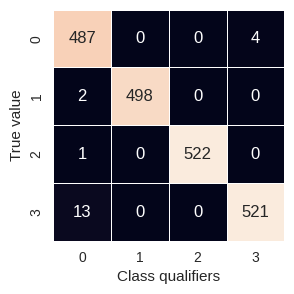

In [ ]:
#@title Confusion matrix for test data
mat = confusion_matrix(y_test, y_pred_test_data) #
fig =  plt.figure(figsize=(10, 3), facecolor='1')
# ax = plt.axes()
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt="d", linewidths=0.5)
plt.xlabel('Class qualifiers') # Predict
plt.ylabel('True value'); # Test True

In [ ]:
#@title Save test frames to pict
ind_class = np.argwhere((y_test==0) & (y_pred_test_data==3))# select
# ind_class = np.argwhere(y_avicon<5) # All
print(ind_class.shape, ' - Check len' )
print(ind_class)

!rm -rf '/content/sample_data/save_1/'
!mkdir '/content/sample_data/save_1/'
!rm '/content/sample_data/pict.zip'
for i in np.reshape(ind_class, (ind_class.shape[0])):
  # Check shape of data tensors and visualization
  expl, label = Read_one_example(patch_dir_file=test_dir,
                      batch_size=1,
                      frame_size=FRAME_SIZE,
                      num_classes=NUM_CLASSES,
                      reshape=False,
                      tocategor=False,
                      shuff=False,
                      norm=True,
                      index_example=i)
  example = expl.copy()
  example[example > 0] = 1
  example = np.rot90(example, k=1, axes=(1, 2))[0] # rotation internal matrix
  example = np.reshape(example, (example.shape[0], example.shape[1], 1))
  image_m = example
  image_m = (image_m * 255).astype('uint8')
  cv2.imwrite('/content/sample_data/save_1/' + f"{i}.png", image_m)

!zip -r '/content/sample_data/pict.zip' '/content/sample_data/save_1/'

(4, 1)  - Check len
[[ 757]
 [1148]
 [1546]
 [1784]]
  adding: content/sample_data/save_1/ (stored 0%)
  adding: content/sample_data/save_1/757.png (deflated 62%)
  adding: content/sample_data/save_1/1546.png (deflated 56%)
  adding: content/sample_data/save_1/1148.png (deflated 57%)
  adding: content/sample_data/save_1/1784.png (deflated 52%)


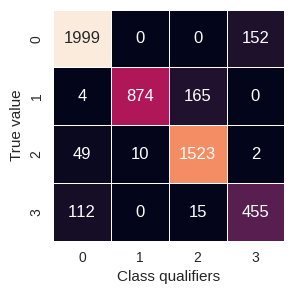

In [ ]:
#@title Confusion matrix for Avicon data
mat = confusion_matrix(y_avicon, y_pred_avicon_data)
fig =  plt.figure(figsize=(10, 3), facecolor='1')
# ax = plt.axes()
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt="d", linewidths=0.5)
plt.xlabel('Class qualifiers') # Predict
plt.ylabel('True value'); # Real TRUE

In [ ]:
#@title Save avicon frames to pict
ind_class = np.argwhere((y_avicon==3) & (y_pred_avicon_data==0))
# ind_class = np.argwhere(y_avicon<5) # All
print(ind_class.shape, ' - Check len' )
print(ind_class)

!rm -rf '/content/sample_data/save_1/'
!mkdir '/content/sample_data/save_1/'
!rm '/content/sample_data/pict.zip'
for i in np.reshape(ind_class, (ind_class.shape[0])):
  # Check shape of data tensors and visualization
  expl, label = Read_one_example(patch_dir_file=test_avikon_dir,
                      batch_size=1,
                      frame_size=FRAME_SIZE,
                      num_classes=NUM_CLASSES,
                      reshape=False,
                      tocategor=False,
                      shuff=False,
                      norm=True,
                      index_example=i)
  example = expl.copy()
  example[example > 0] = 1
  example = np.rot90(example, k=1, axes=(1, 2))[0] # rotation internal matrix
  example = np.reshape(example, (example.shape[0], example.shape[1], 1))
  image_m = example
  image_m = (image_m * 255).astype('uint8')
  cv2.imwrite('/content/sample_data/save_1/' + f"{i}.png", image_m)

!zip -r '/content/sample_data/pict.zip' '/content/sample_data/save_1/'

[0 1 2 3]  имеющиеся класы
[2 1 0 0 3 2 0 3 1 0 3 3 2 2 1 3 2 3 3 0 0 3 1 0 2 1 2 3 1 0 1 3]  example y_test .. 
[[0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]] example y_onehot_test ... 


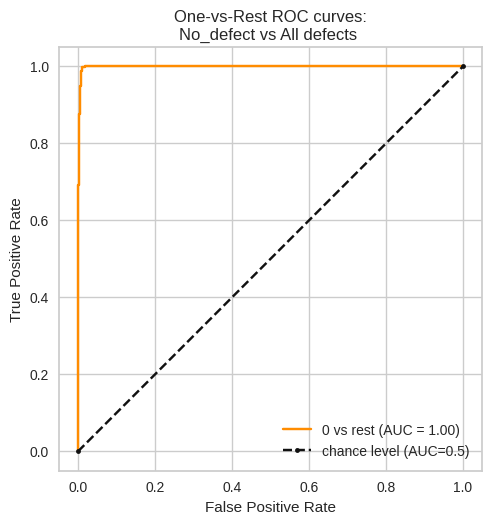

In [ ]:
#@title Build ROC curve for test data
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

y_test = y_test #
y_model_sim = y_pred #

label_binarizer = LabelBinarizer().fit(y_test)
print(label_binarizer.classes_, ' exist classes')
y_onehot_test = label_binarizer.transform(y_test)
print(y_test[0:32], ' example y_test .. ')
print(y_onehot_test[0:5,:], 'example y_onehot_test ... ')
class_of_interest = 0 #
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(y_true=y_onehot_test[:, class_id],
                                 y_pred=y_model_sim[:, class_id],
                                 name=f'{class_of_interest} vs rest',
                                 color='darkorange')
plt.plot([0, 1], [0, 1], '.k--', label='chance level (AUC=0.5)')
plt.axis('square')
# plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC curves:\nNo_defect vs All defects ')
plt.legend()
# plt.show()
fpr, tpr, thresholds = roc_curve(y_true=y_onehot_test[:, class_id],
                                 y_score=y_model_sim[:, class_id])

In [ ]:
#@title Build    Figure precision_vs_recall   for test data
from sklearn.metrics import precision_recall_curve
pr, rec, thr = precision_recall_curve(y_true=y_onehot_test[:, class_id],
                                      probas_pred=y_model_sim[:, class_id])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thr, pr[:len(thr)], 'b-', label='precision')
ax.plot(thr, rec[:len(thr)],'r-', label = 'recall')

ax.set_xlabel('Thresholds')
ax.set_ylabel('Rating')
ax.set_ylim([0.9, 1.005])
ax.legend()

y_pred_no_def = y_model_sim[:, class_id].copy()
level = 0.5
y_pred_no_def[y_pred_no_def >= level] = 1
y_pred_no_def[y_pred_no_def < level] = 0
b = y_pred_no_def[y_pred_no_def >= level]
print(len(b),' нулей больше порога level')
target_names = ['Defects', 'NO defect']
print(classification_report(y_true=y_onehot_test[:, class_id], y_pred=y_pred_no_def, digits=4, target_names=target_names))
mat = confusion_matrix(y_true=y_onehot_test[:, class_id], y_pred=y_pred_no_def)
fig = plt.figure(figsize=(3, 3), facecolor='1')
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='d', linewidths=0.5,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('сlass qualifiers'); plt.ylabel('true value'); plt.title(f'Threshold={level}')

[0 1 2 3]  имеющиеся класы
[1 2 3 2 0 3 2 0 0 0 0 2 1 1 0 3 3 1 2 0 0 0 0 2 0 3 0 0 0 2 2 1]  example y_test .. 
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]] example y_onehot_test ... 


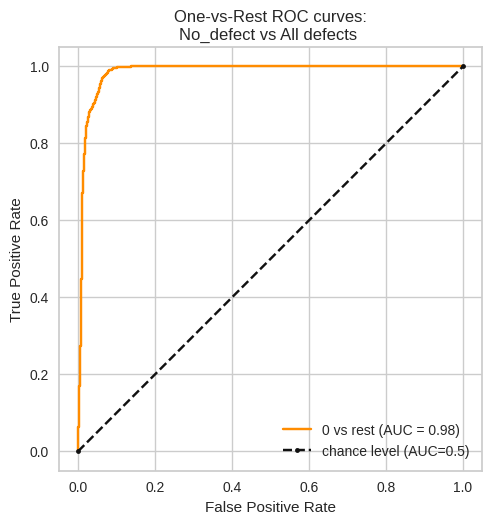

In [ ]:
#@title Build ROC curve for avicon data
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

y_test =y_avicon #
y_model = y_pred_avicon_data_hot

label_binarizer = LabelBinarizer().fit(y_test)
print(label_binarizer.classes_, ' имеющиеся класы')
y_onehot_test = label_binarizer.transform(y_test)
print(y_test[0:32], ' example y_test .. ')
print(y_onehot_test[0:5,:], 'example y_onehot_test ... ')
class_of_interest = 0 #
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

RocCurveDisplay.from_predictions(y_true=y_onehot_test[:, class_id],
                                 y_pred=y_model[:, class_id],
                                 name=f'{class_of_interest} vs rest',
                                 color='darkorange')
plt.plot([0, 1], [0, 1], '.k--', label='chance level (AUC=0.5)')
plt.axis('square')
# plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC curves:\nNo_defect vs All defects ')
plt.legend()
# plt.show()
fpr, tpr, thresholds = roc_curve(y_true=y_onehot_test[:, class_id],
                                 y_score=y_model[:, class_id])

1769  нулей больше порога level
              precision    recall  f1-score   support

     Defects     0.8775    0.9819    0.9268      3209
   NO defect     0.9672    0.7954    0.8730      2151

    accuracy                         0.9071      5360
   macro avg     0.9223    0.8887    0.8999      5360
weighted avg     0.9135    0.9071    0.9052      5360



Text(0.5, 1.0, 'Threshold=0.9')

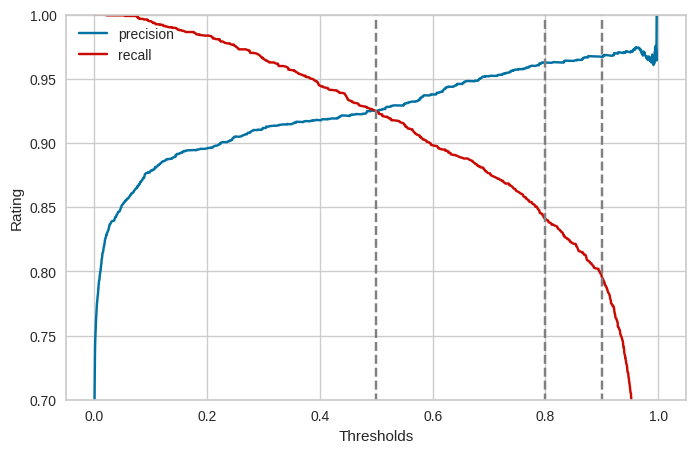

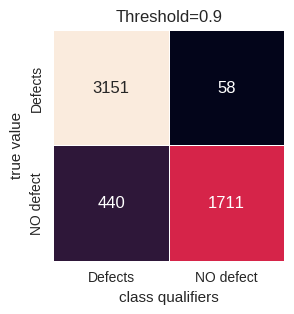

In [ ]:
#@title Build    Figure precision_vs_recall   for avicon data
from sklearn.metrics import precision_recall_curve
pr, rec, thr = precision_recall_curve(y_true=y_onehot_test[:, class_id],
                                      probas_pred=y_model[:, class_id])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thr, pr[:len(thr)], 'b-', label='precision')
ax.plot(thr, rec[:len(thr)],'r-', label = 'recall')

ax.set_xlabel('Thresholds')
ax.set_ylabel('Rating')
ax.set_ylim([0.7, 1.000])
ax.legend(loc='upper left')
ax.vlines(0.5, 0.2, 1.01, color='gray', linestyle='dashed')
ax.vlines(0.8, 0.2, 1.01, color='gray', linestyle='dashed')
ax.vlines(0.9, 0.2, 1.01, color='gray', linestyle='dashed')

y_pred_no_def = y_model[:, class_id].copy()
level = 0.9 # 0.86
y_pred_no_def[y_pred_no_def >= level] = 1
y_pred_no_def[y_pred_no_def < level] = 0
b = y_pred_no_def[y_pred_no_def >= level]
print(len(b),' above the level threshold')
target_names = ['Defects', 'NO defect']
print(classification_report(y_true=y_onehot_test[:, class_id], y_pred=y_pred_no_def, digits=4, target_names=target_names))
mat = confusion_matrix(y_true=y_onehot_test[:, class_id], y_pred=y_pred_no_def)
fig = plt.figure(figsize=(3, 3), facecolor='1')
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='d', linewidths=0.5,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('сlass qualifiers'); plt.ylabel('true value'); plt.title(f'Threshold={level}')

# **Sparse Tensor**

In [ ]:
#@title Spares tensors
chek = Arr_DataGenerator(patch_dir_file=train_dir,
                         batch_size=BATCH_SIZE,
                         frame_size=FRAME_SIZE,
                         num_classes=NUM_CLASSES,
                         shuff=False,
                         norm=True,
                         reshape=False,
                         tocategor=False)
check_data, check_labels = next(chek)
print(check_data.shape, ' - Data shape ')
print(check_labels.shape, ' - Label shape')
print(check_data.dtype)
print(check_data.max())
spt = tf.sparse.from_dense(check_data)
print(spt)
# dan = tf.sparse.to_dense(spt)
# print(dan.shape)

data = tf.data.Dataset.from_tensor_slices(spt)
label = tf.data.Dataset.from_tensor_slices(check_labels).map(py_categor)
print(label)
ds =  tf.data.Dataset.zip(data, label)
ds = configure_for_performance(ds=ds, batch_size=2)
print('*****************************')
for f in ds.take(2):
  print(f)

In [ ]:
#@title FUNC for building Block_Conv2D

def block(inp=tf.keras.Input(shape=FRAME_SIZE + (1,), dtype='float32', name='inp'),
          filters=(4, 8),
          first_blk=False,
          name='Blk_'):
  if first_blk==False:
    inp = layers.MaxPooling2D((2, 2), name=name + '_1')(inp)
  x = layers.Conv2D(filters=filters[0], kernel_size=(2, 2), padding='valid', activation='relu', name=name + '_2')(inp)
  x = layers.BatchNormalization(name=name+'_3')(x)
  x = layers.Conv2D(filters=filters[1], kernel_size=(2, 2), padding='valid', activation='relu', name=name + '_4')(x)

  block_out = x
  return block_out

In [ ]:
import scipy
trainX = scipy.sparse.random(1024, 1024)
print(trainX)
trainY = np.random.rand(1024, 1024)
print(trainY)
inputs = Input(shape=(trainX.shape[1],), sparse=True)
outputs = layers.Dense(trainY.shape[1], activation='softmax')(inputs)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps = 10
for i in range(steps):
  # For simplicity, we directly use trainX and trainY in this example
  # Usually, this is where batches are prepared
  print(model.train_on_batch(trainX, trainY))


In [ ]:
# Create a dense matrix
d = np.random.random((4, 5, 3))
d[d<0.8] = 0
print(d.shape)
# print(d)
# Convert the dense matrix to a sparse matrix
s= tf.sparse.from_dense(d)
print('shape sparse {}'.format(s.shape))
print(s)
# Build the model
inp = Input(shape=(3), sparse=True)
# x = layers.Conv2D(filters=2, kernel_size=(1, 1), padding='valid', activation='relu')(inp)
# x = layers.Flatten()(inp)
out = layers.Dense(32, activation='relu')(inp)
model = Model(inp, out)
model.summary()
# model = Sequential()
# model.add(layers.Flatten())
# model.add(Dense(64,  activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


(4, 5, 3)
shape sparse (4, 5, 3)
SparseTensor(indices=tf.Tensor(
[[0 2 2]
 [0 3 0]
 [0 4 0]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 1 0]
 [2 1 1]
 [2 2 1]
 [2 4 1]
 [3 0 0]
 [3 1 2]
 [3 2 2]
 [3 3 0]
 [3 4 0]
 [3 4 1]], shape=(16, 3), dtype=int64), values=tf.Tensor(
[0.83822984 0.99515051 0.89596271 0.87047135 0.97691903 0.87062128
 0.84255808 0.91515359 0.97370491 0.83486555 0.8325233  0.83992318
 0.97939619 0.84610088 0.83109818 0.82204409], shape=(16,), dtype=float64), dense_shape=tf.Tensor([4 5 3], shape=(3,), dtype=int64))
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                128       
                                                                 
Total params: 128 (512.00 Byte)
Trainable params: 128 (512.00 

In [ ]:
np.array((0, 0, 0, 0, 0, 1), dtype='float32')

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
x = tf.keras.Input(shape=(9,), sparse=True)
y = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(x, y)

sparse_data = tf.SparseTensor(
    indices = [(0,0),(0,1),(0,2),
               (4,3),(5,0),(5,1)],
    values = [1,1,1,1,1,1],
    dense_shape = (6,9)
)
ss = sparse_data

d = np.random.random((5, 9))
d[d<0.8] = 0
print(d.shape)

aa = tf.sparse.from_dense(d)

# model(sparse_data)
data = tf.data.Dataset.from_tensor_slices(aa)
# label = tf.data.Dataset.from_tensor_slices(check_labels).map(py_categor)
# print(label)
# ds =  tf.data.Dataset.zip(data, label)
ds= data
ds = configure_for_performance(ds=ds, batch_size=1)
print('++++*****************************')
for f in ds.take(1):
  print(tf.sparse.to_dense(f).shape)
  print(model.predict(x=f))
  print('******************************')
# print(ss)
print(tf.sparse.to_dense(ss))
print(tf.sparse.to_dense(ss).shape)
print('******************************')
print(model.predict(ss))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
print(np.array([0]))
model.fit(ss, np.array((0, 0, 0, 0, 0, 1), dtype='float32'))


(5, 9)
++++*****************************
(1, 9)
1/1 [==============================] - 0s 176ms/step
[[ 4.1106075e-01 -2.6630622e-01  7.6748864e-03  1.4185338e-01
  -2.2863346e-04 -3.0888665e-01  2.3998009e-01 -1.4005665e-01
   7.0156194e-02  1.2418230e-01]]
******************************
tf.Tensor(
[[1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]], shape=(6, 9), dtype=int32)
(6, 9)
******************************
1/1 [==============================] - 0s 155ms/step
[[ 6.1569631e-01 -5.2538431e-01 -8.8545591e-02 -7.4804240e-01
  -8.5573626e-01 -1.0316055e+00  9.8553300e-03  2.0867169e-01
  -1.5843561e-01  1.0186346e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+0

ValueError: ignored

In [ ]:
#@title Model_1

tf.keras.backend.clear_session() # сбросить состояние модели в памяти

def get_model_1(filters=[(4, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256)], sparse=True):
  inp = tf.keras.Input(shape=FRAME_SIZE + (1,), dtype='float32', name='data_frame', sparse=sparse)
  b = inp
  first_blk=True
  for i in range(len(filters)):
    print(i, '****' )
    # print(filters[i])
    if i!=0:
      first_blk = False
    # print(first_blk)
    name = f'blk_{i+1}'
    b = block(inp=b, filters=filters[i], first_blk=first_blk, name=name)
  out = layers.Flatten()(b)
  out = layers.Dense(units=16, activation='relu')(out)
  out = layers.Dense(units=NUM_CLASSES, activation='softmax')(out)
  model = Model(inp, out)
  return model

# (4, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256)
# (4, 8), (8, 16), (16, 32), (32, 64)
# (2, 4), (4, 8), (8, 16), (16, 32), (32, 64), (64, 64)
model_1 = get_model_1(filters=[(2, 4), (4, 4), (4, 8), (8, 8), (16, 16), (16, 32)], sparse=True)
model_1.summary()

0 ****


TypeError: ignored

In [ ]:
#@title Compilation model
model = model_1
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

# **Проба example**

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
print(_bytes_feature(b'test_string'))
print(_float_feature(np.exp(1)))
print(_float_feature(np.exp(1)).SerializeToString())

a = np.linspace(0, 1, 5)
print('\nSet numpy arr : \n', type(a), '\n',  a)

ser_nonscalar = tf.io.serialize_tensor(tensor=a)
print('Serialized Arr :\n', ser_nonscalar)

print('DeSerialise Arr: ')
b = tf.io.parse_tensor(serialized=ser_nonscalar, out_type=tf.float64)
print(type(b))
print(b)

bytes_list {
  value: "test_string"
}

float_list {
  value: 2.7182817459106445
}

b'\x12\x06\n\x04T\xf8-@'

Set numpy arr : 
 <class 'numpy.ndarray'> 
 [0.   0.25 0.5  0.75 1.  ]
Serialized Arr :
 tf.Tensor(b'\x08\x02\x12\x04\x12\x02\x08\x05"(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd0?\x00\x00\x00\x00\x00\x00\xe0?\x00\x00\x00\x00\x00\x00\xe8?\x00\x00\x00\x00\x00\x00\xf0?', shape=(), dtype=string)
DeSerialise Arr: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.   0.25 0.5  0.75 1.  ], shape=(5,), dtype=float64)


In [ ]:
n = 100
feature0 = np.random.choice([False, True], n)
feature1 = np.random.randint(0, 5, n)
stringArr = np.array([b'cat', b'bird', b'dog', b'horse', b'got'])
feature2 = stringArr[feature1]
feature3 = np.random.randn(n)

In [ ]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

print('Serialisation data:')
ser_exmpl = serialize_example(False, 4, b'horse', 0.245)
print(ser_exmpl)
print('Deserialization: ')
deser_exmpl = tf.train.Example.FromString(ser_exmpl)
print(deser_exmpl)

Serialisation data:
b'\nS\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04H\xe1z>'
Deserialization: 
features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "horse"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.24500000476837158
      }
    }
  }
}



In [ ]:
tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [ ]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
# h = iter(feature_dataset.batch(2))
# next(h)
for f0, f1, f2, f3 in features_dataset.take(2):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'bird', shape=(), dtype=string)
tf.Tensor(-2.018205203091308, shape=(), dtype=float64)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(-0.4228283987325234, shape=(), dtype=float64)


In [ ]:
def tf_serialize_example(f0, f1, f2, f3):
  # Функция которая может применяться для map
  tf_string = tf.py_function(func=serialize_example,
                             inp=(f0, f1, f2, f3),
                             Tout=tf.string) # The return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar.
a = tf_serialize_example(f0=False, f1=4, f2=b'horse', f3=0.245)
print('Пример сериализвации одного экземпляра', a)

serialized_features_dataset = features_dataset.map(tf_serialize_example)
print('Сериализованный набор :', serialized_features_dataset)

# Пример записи в файл
filename = 'test1.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

# Второй пример записи в файл
with tf.io.TFRecordWriter('test2.tfrecord') as file_writer:
  for i in range(len(feature0)):
    record_bytes = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    file_writer.write(record_bytes)


Пример сериализвации одного экземпляра tf.Tensor(b'\nS\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04H\xe1z>\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse', shape=(), dtype=string)


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


Сериализованный набор : <_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


<ipython-input-11-e37bb0a85fdd>:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [ ]:
dat = np.arange(0, 5*4*3, 1)
dat = np.reshape(dat, (5, 4, 3)).astype(dtype=np.uint8)
lab = np.arange(0, 5, 1)
elem = dat[0]
print('Befor Serialisiz: \n', elem, '\n', type(elem) )
a = tf.io.serialize_tensor(elem)
print('Serializ Arr: \n', a)
feature_of_bytes = tf.train.Feature(bytes_list=tf.train.BytesList(value=[a.numpy()]))
print('Feature_of_bytes : \n ', feature_of_bytes)
features_for_example = {'feature0': feature_of_bytes}
example_proto = tf.train.Example(
    features=tf.train.Features(feature=features_for_example))
example_proto

Befor Serialisiz: 
 [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]] 
 <class 'numpy.ndarray'>
Serializ Arr: 
 tf.Tensor(b'\x08\x04\x12\x08\x12\x02\x08\x04\x12\x02\x08\x03"\x0c\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b', shape=(), dtype=string)
Feature_of_bytes : 
  bytes_list {
  value: "\010\004\022\010\022\002\010\004\022\002\010\003\"\014\000\001\002\003\004\005\006\007\010\t\n\013"
}



features {
  feature {
    key: "feature0"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\004\022\002\010\003\"\014\000\001\002\003\004\005\006\007\010\t\n\013"
      }
    }
  }
}

In [ ]:

with tf.io.TFRecordWriter('test3.tfrecord') as file_writer:

  for i in range(dat.shape[0]):
    elem = dat[i].flatten().astype(dtype=np.uint8)
    record_byte = tf.io.serialize_tensor(elem)
    record_byte = record_byte.numpy()
    file_writer.write(record_byte)
   # 'label': _int64_feature(int(lab[i])),

In [ ]:
# Read from file
parse_tensor_f32 = lambda x: tf.io.parse_tensor(x, tf.uint8)
ds = (tf.data.TFRecordDataset('test3.tfrecord')
      .map(parse_tensor_f32))
for f in ds.batch(2).take(2):
  print(f)
# i=0
# for x3 in ds:
#   print(i)
#   i += 1
#   tf.print(x3)

tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]], shape=(2, 12), dtype=uint8)
tf.Tensor(
[[24 25 26 27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44 45 46 47]], shape=(2, 12), dtype=uint8)


In [ ]:
x = tf.constant([[2.0, 3.0, 3.0],
                 [1.0, 5.0, 9.0]], dtype='float32')
x2 = tf.io.serialize_tensor(x)
record_file = 'temp2.tfrecord'
with tf.io.TFRecordWriter(record_file) as writer:
    # Get value with .numpy()
    writer.write(x2.numpy())
# Read from file
parse_tensor_f32 = lambda x: tf.io.parse_tensor(x, tf.float32)
ds = (tf.data.TFRecordDataset('temp2.tfrecord')
      .map(parse_tensor_f32))
for x3 in ds:
    tf.print(x3)

[[2 3 3]
 [1 5 9]]


In [ ]:
x = tf.constant([[2.0, 3.0, 3.0],
                 [1.0, 5.0, 9.0]], dtype='float32')
# Write to file
ds = (tf.data.Dataset.from_tensors(x)
      .map(tf.io.serialize_tensor))
writer = tf.data.experimental.TFRecordWriter('temp.tfrecord')
writer.write(ds)

In [ ]:
scalars = [1, 2, 3]
vectors = np.arange(0, 3 * 4, 1)
vectors = np.reshape(vectors, (3, 4))
print(vectors.shape)
matrixs = np.arange(0, 3 * 2 * 3, 1)
matrixs = np.reshape(matrixs, (3, 2, 3))
print(matrixs.shape)
tensors = np.arange(0, 3 * 4 * 2 * 3, 1)
tensors = np.reshape(tensors, (3, 4, 2, 3))
print(tensors.shape)
for i in range(3):
  # Словарь
  features={}
  features['scalar'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[scalars[i]]))
  features['vector'] = tf.train.Feature(float_list=tf.train.FloatList(value=vectors[i]))
  features['matrix'] = tf.train.Feature(float_list=tf.train.FloatList(value=matrixs[i].flatten()))
  features['bytes_matrix'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[matrixs[i].flatten().tobytes()]))
  features['matrix_shape'] = tf.train.Feature(int64_list=tf.train.Int64List(value=matrixs[i].shape))
  features['tensors'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[tensors[i].tobytes()]))
  features['tensor_shape'] = tf.train.Feature(int64_list=tf.train.Int64List(value=tensors[i].shape))

  tf_features = tf.train.Features(feature=features)
  tf_example = tf.train.Example(features=tf_features)

  tf_serialized = tf_example.SerializeToString()
  print(tf_serialized)
  print('**********************')
features
# tf_serialized